In [3]:
# basic
import pandas as pd
import numpy as np
import xgboost as xgb

# viz
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor

# custom config
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [4]:
# MPL Settings
%config InlineBackend.figure_format = 'svg'

mpl.rcParams["font.family"] = "Arial"
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams["figure.figsize"] = [10, 8]
%matplotlib inline

grey = '#808080'
darkgrey = '#505050'
# (http://www.color-hex.com/color/505050)

mpl.rcParams['axes.linewidth'] = 0.3
mpl.rcParams['axes.edgecolor'] = grey
mpl.rcParams['xtick.color'] = grey
mpl.rcParams['ytick.color'] = grey
mpl.rcParams['text.color'] = darkgrey
mpl.rcParams['axes.labelcolor'] = darkgrey

In [5]:
csv_loc = 'https://www.kaggle.com/HRAnalyticRepository/employee-attrition-data#:~:text=calendar_view_week-,MFG10YearTerminationData,-.csv'

In [6]:
# !curl {csv_loc} -o MFG10YearTerminationData.csv

In [7]:
df = pd.read_csv('MFG10YearTerminationData.csv', parse_dates=[ 
    'recorddate_key',
 'birthdate_key',
 'orighiredate_key',
 'terminationdate_key',])
df.shape
df.dtypes
df.head(10)


(49653, 18)

EmployeeID                      int64
recorddate_key         datetime64[ns]
birthdate_key          datetime64[ns]
orighiredate_key       datetime64[ns]
terminationdate_key    datetime64[ns]
age                             int64
length_of_service               int64
city_name                      object
department_name                object
job_title                      object
store_name                      int64
gender_short                   object
gender_full                    object
termreason_desc                object
termtype_desc                  object
STATUS_YEAR                     int64
STATUS                         object
BUSINESS_UNIT                  object
dtype: object

,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT
0,1318,2006-12-31,1954-01-03,1989-08-28,1900-01-01,52,17,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2006,ACTIVE,HEADOFFICE
1,1318,2007-12-31,1954-01-03,1989-08-28,1900-01-01,53,18,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2007,ACTIVE,HEADOFFICE
2,1318,2008-12-31,1954-01-03,1989-08-28,1900-01-01,54,19,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2008,ACTIVE,HEADOFFICE
3,1318,2009-12-31,1954-01-03,1989-08-28,1900-01-01,55,20,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2009,ACTIVE,HEADOFFICE
4,1318,2010-12-31,1954-01-03,1989-08-28,1900-01-01,56,21,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2010,ACTIVE,HEADOFFICE
5,1318,2011-12-31,1954-01-03,1989-08-28,1900-01-01,57,22,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2011,ACTIVE,HEADOFFICE
6,1318,2012-12-31,1954-01-03,1989-08-28,1900-01-01,58,23,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2012,ACTIVE,HEADOFFICE
7,1318,2013-12-31,1954-01-03,1989-08-28,1900-01-01,59,24,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2013,ACTIVE,HEADOFFICE
8,1318,2014-12-31,1954-01-03,1989-08-28,1900-01-01,60,25,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2014,ACTIVE,HEADOFFICE
9,1318,2015-12-31,1954-01-03,1989-08-28,1900-01-01,61,26,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2015,ACTIVE,HEADOFFICE


In [8]:
# Active vs Churned

df.EmployeeID.nunique()
df.STATUS.value_counts()
global_attr_rate = round((df[df.STATUS=='TERMINATED'].EmployeeID.nunique()/df.EmployeeID.nunique()), 3)
global_attr_rate

6284

ACTIVE        48168
TERMINATED     1485
Name: STATUS, dtype: int64

0.236

So employee attrition rate is ~24%

In [9]:
cols = list(df.columns)
cols

['EmployeeID',
 'recorddate_key',
 'birthdate_key',
 'orighiredate_key',
 'terminationdate_key',
 'age',
 'length_of_service',
 'city_name',
 'department_name',
 'job_title',
 'store_name',
 'gender_short',
 'gender_full',
 'termreason_desc',
 'termtype_desc',
 'STATUS_YEAR',
 'STATUS',
 'BUSINESS_UNIT']

In [10]:
categorical = cols.copy()

for i in ['EmployeeID', 'recorddate_key',
 'birthdate_key',
 'orighiredate_key',
 'terminationdate_key']:
    categorical.remove(i)

In [11]:
categorical
for c in categorical:
    f'value counts for {c}:' 
    df[c].value_counts()

['age',
 'length_of_service',
 'city_name',
 'department_name',
 'job_title',
 'store_name',
 'gender_short',
 'gender_full',
 'termreason_desc',
 'termtype_desc',
 'STATUS_YEAR',
 'STATUS',
 'BUSINESS_UNIT']

'value counts for age:'

27    1235
29    1227
28    1225
50    1218
30    1212
26    1210
51    1207
25    1197
49    1196
35    1189
34    1188
53    1188
52    1188
48    1180
36    1176
47    1173
55    1168
33    1164
46    1161
54    1159
44    1157
38    1156
56    1154
32    1153
42    1152
43    1150
37    1149
31    1146
39    1142
45    1141
41    1135
58    1130
57    1130
40    1130
59    1128
24    1111
60    1109
23     960
22     815
61     757
62     712
21     703
63     667
64     646
65     593
20     408
19     158
Name: age, dtype: int64

'value counts for length_of_service:'

13    2885
12    2567
8     2559
11    2482
10    2432
9     2381
7     2341
6     2294
3     2270
4     2262
5     2258
2     2257
1     2222
14    2203
15    2192
16    2160
17    2066
0     1962
18    1829
19    1656
20    1322
21    1047
22     830
23     608
24     433
25     121
26      14
Name: length_of_service, dtype: int64

'value counts for city_name:'

Vancouver           11211
Victoria             4885
Nanaimo              3876
New Westminster      3211
Kelowna              2513
Burnaby              2067
Kamloops             2061
Prince George        2048
Cranbrook            1785
Surrey               1560
Richmond             1401
Terrace              1228
Chilliwack           1167
Trail                 925
Langley               901
Vernon                898
Squamish              806
Quesnel               703
Abbotsford            681
North Vancouver       648
Fort St John          621
Williams Lake         617
West Vancouver        613
Port Coquitlam        545
Aldergrove            520
Fort Nelson           322
Nelson                317
New Westminister      254
Grand Forks           236
White Rock            231
Haney                 182
Princeton             136
Dawson Creek          129
Bella Bella           126
Ocean Falls            65
Pitt Meadows           57
Cortes Island          43
Valemount              37
Dease Lake  

'value counts for department_name:'

Meats                     10269
Dairy                      8599
Produce                    8515
Bakery                     8381
Customer Service           7122
Processed Foods            5911
Store Management            271
Executive                   100
Recruitment                  72
HR Technology                64
Accounting                   59
Employee Records             44
Accounts Receiveable         39
Labor Relations              34
Accounts Payable             34
Training                     30
Compensation                 24
Audit                        24
Investment                   24
Information Technology       20
Legal                        17
Name: department_name, dtype: int64

'value counts for job_title:'

Meat Cutter                        9984
Dairy Person                       8590
Produce Clerk                      8237
Baker                              8096
Cashier                            6816
Shelf Stocker                      5622
Customer Service Manager            306
Processed Foods Manager             289
Bakery Manager                      285
Meats Manager                       285
Produce Manager                     278
Store Manager                       271
Recruiter                            62
HRIS Analyst                         55
Accounting Clerk                     50
Benefits Admin                       35
Labor Relations Analyst              30
Accounts Receiveable Clerk           30
Trainer                              26
Accounts Payable Clerk               25
Auditor                              20
Systems Analyst                      20
Investment Analyst                   20
Compensation Analyst                 20
Corporate Lawyer                     17


'value counts for store_name:'

46    4422
18    3876
42    3827
21    3211
43    2896
16    2513
5     2067
15    2061
26    2048
8     1785
41    1765
31    1560
44    1520
29    1401
32    1228
6     1167
35    1143
33     925
17     901
36     898
30     806
28     703
1      681
22     648
12     621
40     617
38     613
25     545
2      520
37     463
11     322
19     317
20     254
13     236
39     231
14     182
27     136
9      129
3      126
23      65
45      60
24      57
7       43
34      37
10      18
4        9
Name: store_name, dtype: int64

'value counts for gender_short:'

F    25898
M    23755
Name: gender_short, dtype: int64

'value counts for gender_full:'

Female    25898
Male      23755
Name: gender_full, dtype: int64

'value counts for termreason_desc:'

Not Applicable    48168
Retirement          885
Resignaton          385
Layoff              215
Name: termreason_desc, dtype: int64

'value counts for termtype_desc:'

Not Applicable    48168
Voluntary          1270
Involuntary         215
Name: termtype_desc, dtype: int64

'value counts for STATUS_YEAR:'

2013    5320
2012    5231
2014    5215
2011    5082
2010    4963
2015    4961
2009    4852
2008    4767
2007    4683
2006    4579
Name: STATUS_YEAR, dtype: int64

'value counts for STATUS:'

ACTIVE        48168
TERMINATED     1485
Name: STATUS, dtype: int64

'value counts for BUSINESS_UNIT:'

STORES        49068
HEADOFFICE      585
Name: BUSINESS_UNIT, dtype: int64

In [12]:
term_emps = df.loc[df['STATUS']=='TERMINATED', 'EmployeeID']
df[df['EmployeeID'].isin(term_emps)].sort_values(['EmployeeID', 'recorddate_key']).head(10)
df[df['EmployeeID']==1338]

,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT
140,1338,2006-12-31,1949-02-16,1989-09-20,2009-02-16,57,17,Vancouver,Training,"Director, Training",35,M,Male,Not Applicable,Not Applicable,2006,ACTIVE,HEADOFFICE
141,1338,2007-12-31,1949-02-16,1989-09-20,2009-02-16,58,18,Vancouver,Training,"Director, Training",35,M,Male,Not Applicable,Not Applicable,2007,ACTIVE,HEADOFFICE
142,1338,2008-12-31,1949-02-16,1989-09-20,2009-02-16,59,19,Vancouver,Training,"Director, Training",35,M,Male,Not Applicable,Not Applicable,2008,ACTIVE,HEADOFFICE
48168,1338,2009-02-01,1949-02-16,1989-09-20,2009-02-16,60,19,Vancouver,Training,"Director, Training",35,M,Male,Retirement,Voluntary,2009,TERMINATED,HEADOFFICE
143,1339,2006-12-31,1949-02-19,1989-09-22,2014-02-19,57,17,Nelson,Store Management,Store Manager,19,F,Female,Not Applicable,Not Applicable,2006,ACTIVE,STORES
144,1339,2007-12-31,1949-02-19,1989-09-22,2014-02-19,58,18,Nelson,Store Management,Store Manager,19,F,Female,Not Applicable,Not Applicable,2007,ACTIVE,STORES
145,1339,2008-12-31,1949-02-19,1989-09-22,2014-02-19,59,19,Nelson,Store Management,Store Manager,19,F,Female,Not Applicable,Not Applicable,2008,ACTIVE,STORES
146,1339,2009-12-31,1949-02-19,1989-09-22,2014-02-19,60,20,Nelson,Store Management,Store Manager,19,F,Female,Not Applicable,Not Applicable,2009,ACTIVE,STORES
147,1339,2010-12-31,1949-02-19,1989-09-22,2014-02-19,61,21,Nelson,Store Management,Store Manager,19,F,Female,Not Applicable,Not Applicable,2010,ACTIVE,STORES
148,1339,2011-12-31,1949-02-19,1989-09-22,2014-02-19,62,22,Nelson,Store Management,Store Manager,19,F,Female,Not Applicable,Not Applicable,2011,ACTIVE,STORES


,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT
140,1338,2006-12-31,1949-02-16,1989-09-20,2009-02-16,57,17,Vancouver,Training,"Director, Training",35,M,Male,Not Applicable,Not Applicable,2006,ACTIVE,HEADOFFICE
141,1338,2007-12-31,1949-02-16,1989-09-20,2009-02-16,58,18,Vancouver,Training,"Director, Training",35,M,Male,Not Applicable,Not Applicable,2007,ACTIVE,HEADOFFICE
142,1338,2008-12-31,1949-02-16,1989-09-20,2009-02-16,59,19,Vancouver,Training,"Director, Training",35,M,Male,Not Applicable,Not Applicable,2008,ACTIVE,HEADOFFICE
48168,1338,2009-02-01,1949-02-16,1989-09-20,2009-02-16,60,19,Vancouver,Training,"Director, Training",35,M,Male,Retirement,Voluntary,2009,TERMINATED,HEADOFFICE


In [13]:
df['emp_record_idx'] = df.groupby('EmployeeID')['recorddate_key'].rank(method='first')


In [14]:
df = df.copy().sort_values(['EmployeeID', 'recorddate_key'])
df[df['EmployeeID']==1338]

,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT,emp_record_idx
140,1338,2006-12-31,1949-02-16,1989-09-20,2009-02-16,57,17,Vancouver,Training,"Director, Training",35,M,Male,Not Applicable,Not Applicable,2006,ACTIVE,HEADOFFICE,1.0
141,1338,2007-12-31,1949-02-16,1989-09-20,2009-02-16,58,18,Vancouver,Training,"Director, Training",35,M,Male,Not Applicable,Not Applicable,2007,ACTIVE,HEADOFFICE,2.0
142,1338,2008-12-31,1949-02-16,1989-09-20,2009-02-16,59,19,Vancouver,Training,"Director, Training",35,M,Male,Not Applicable,Not Applicable,2008,ACTIVE,HEADOFFICE,3.0
48168,1338,2009-02-01,1949-02-16,1989-09-20,2009-02-16,60,19,Vancouver,Training,"Director, Training",35,M,Male,Retirement,Voluntary,2009,TERMINATED,HEADOFFICE,4.0


In [15]:
# df['max_age'] = df.groupby('EmployeeID')['age'].transform('max')
# df['max_los'] = df.groupby('EmployeeID')['length_of_service'].transform('max')
df['num_records'] = df.groupby('EmployeeID')['emp_record_idx'].transform('max')



In [16]:
df.groupby('num_records').agg({'EmployeeID': 'nunique'})

df['num_jobs'] = df.groupby('EmployeeID')['job_title'].transform('nunique')



,EmployeeID
num_records,
1.0,146
2.0,256
3.0,398
4.0,384
5.0,338
6.0,301
7.0,315
8.0,287
9.0,322


In [17]:
df[['EmployeeID', 'job_title', 'num_jobs']].tail(20)
df.num_jobs.max()

,EmployeeID,job_title,num_jobs
48148,8330,Cashier,1
48149,8330,Cashier,1
48150,8331,Dairy Person,1
48151,8331,Dairy Person,1
48152,8331,Dairy Person,1
48153,8332,Cashier,1
48154,8332,Cashier,1
48155,8332,Cashier,1
48156,8333,Cashier,1
48157,8333,Cashier,1


1

In [18]:
df.groupby('job_title').agg({'EmployeeID': 'nunique'}).sort_values(['EmployeeID',], ascending=False)
df.groupby('job_title').agg({'EmployeeID': 'nunique'}).sort_values(['EmployeeID',], ascending=False).index

,EmployeeID
job_title,
Meat Cutter,1218
Cashier,1158
Dairy Person,1032
Produce Clerk,1027
Baker,865
Shelf Stocker,704
Store Manager,35
Meats Manager,34
Bakery Manager,33


Index(['Meat Cutter', 'Cashier', 'Dairy Person', 'Produce Clerk', 'Baker',
       'Shelf Stocker', 'Store Manager', 'Meats Manager', 'Bakery Manager',
       'Produce Manager', 'Processed Foods Manager',
       'Customer Service Manager', 'Recruiter', 'HRIS Analyst',
       'Systems Analyst', 'Benefits Admin', 'Labor Relations Analyst',
       'Accounting Clerk', 'Trainer', 'Accounts Receiveable Clerk',
       'Corporate Lawyer', 'Compensation Analyst', 'Auditor',
       'Accounts Payable Clerk', 'Investment Analyst',
       'Exec Assistant, VP Stores', 'VP Finance', 'VP Human Resources',
       'Legal Counsel', 'Director, Labor Relations',
       'Exec Assistant, Legal Counsel', 'Director, Audit', 'CEO',
       'CHief Information Officer', 'Dairy Manager', 'Director, Accounting',
       'Director, Accounts Payable', 'Director, Accounts Receivable',
       'Director, Compensation', 'Exec Assistant, Human Resources',
       'Director, Employee Records', 'Director, HR Technology',
      

In [19]:
service_staff = ['Meat Cutter', 'Cashier', 'Dairy Person', 'Produce Clerk', 'Baker',
       'Shelf Stocker',]
       
remainder = ['Store Manager', 'Meats Manager', 'Bakery Manager',
       'Produce Manager', 'Processed Foods Manager',
       'Customer Service Manager', 'Recruiter', 'HRIS Analyst',
       'Systems Analyst', 'Benefits Admin', 'Labor Relations Analyst',
       'Accounting Clerk', 'Trainer', 'Accounts Receiveable Clerk',
       'Corporate Lawyer', 'Compensation Analyst', 'Auditor',
       'Accounts Payable Clerk', 'Investment Analyst',
       'Exec Assistant, VP Stores', 'VP Finance', 'VP Human Resources',
       'Legal Counsel', 'Director, Labor Relations',
       'Exec Assistant, Legal Counsel', 'Director, Audit', 'CEO',
       'CHief Information Officer', 'Dairy Manager', 'Director, Accounting',
       'Director, Accounts Payable', 'Director, Accounts Receivable',
       'Director, Compensation', 'Exec Assistant, Human Resources',
       'Director, Employee Records', 'Director, HR Technology',
       'Director, Investments', 'Director, Recruitment', 'Director, Training',
       'Exec Assistant, Finance', 'VP Stores']

In [20]:
df['job_group'] = np.select(
    [
        df['job_title'].isin(service_staff), 
        df['job_title'].str.contains('Analyst|Exec Assistant|Clerk|Recruiter|Trainer|Benefits Admin|Auditor'),
        df['job_title'].str.contains('Legal Counsel|Corporate Lawyer'),
        df['job_title'].str.contains('Manager'),
        df['job_title'].str.contains('Director'),
        df['job_title'].str.contains('VP|CEO|CHief Information Officer')
    ], 
    [
        'Service Staff', 
        'Executive',
        'Legal',
        'Manager',
        'Director',
        'C-Suite'
    ], 
    default='Unknown'
)
df.job_group.value_counts()

Service Staff    47345
Manager           1723
Executive          433
Director            75
C-Suite             50
Legal               27
Name: job_group, dtype: int64

In [21]:
df[df.job_group=='Unknown'].job_title.unique()

array([], dtype=object)

In [22]:
df_max = df[df.emp_record_idx==df.num_records].copy()
df_max['resigned'] = np.where(df_max['termreason_desc']=='Resignaton', 1, 0)
df_max.head()

,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,...,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT,emp_record_idx,num_records,num_jobs,job_group,resigned
9,1318,2015-12-31,1954-01-03,1989-08-28,1900-01-01,61,26,Vancouver,Executive,CEO,...,Not Applicable,Not Applicable,2015,ACTIVE,HEADOFFICE,10.0,10.0,1,C-Suite,0
19,1319,2015-12-31,1957-01-03,1989-08-28,1900-01-01,58,26,Vancouver,Executive,VP Stores,...,Not Applicable,Not Applicable,2015,ACTIVE,HEADOFFICE,10.0,10.0,1,C-Suite,0
29,1320,2015-12-31,1955-01-02,1989-08-28,1900-01-01,60,26,Vancouver,Executive,Legal Counsel,...,Not Applicable,Not Applicable,2015,ACTIVE,HEADOFFICE,10.0,10.0,1,Legal,0
39,1321,2015-12-31,1959-01-02,1989-08-28,1900-01-01,56,26,Vancouver,Executive,VP Human Resources,...,Not Applicable,Not Applicable,2015,ACTIVE,HEADOFFICE,10.0,10.0,1,C-Suite,0
49,1322,2015-12-31,1958-01-09,1989-08-31,1900-01-01,57,26,Vancouver,Executive,VP Finance,...,Not Applicable,Not Applicable,2015,ACTIVE,HEADOFFICE,10.0,10.0,1,C-Suite,0


In [23]:
df_max.groupby('STATUS').agg({'termtype_desc': 'unique', 'termreason_desc': 'unique'})

,termtype_desc,termreason_desc
STATUS,,
ACTIVE,[Not Applicable],[Not Applicable]
TERMINATED,"[Voluntary, Involuntary]","[Retirement, Resignaton, Layoff]"


In [24]:
df[df['termreason_desc']=='Resignaton']

,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,...,gender_full,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT,emp_record_idx,num_records,num_jobs,job_group
48186,1365,2012-09-01,1949-03-24,1989-10-10,2012-09-26,63,22,Fort St John,Store Management,Store Manager,...,Female,Resignaton,Voluntary,2012,TERMINATED,STORES,7.0,7.0,1,Manager
48265,1484,2007-07-01,1949-11-22,1990-02-15,2007-07-25,57,17,Vancouver,HR Technology,HRIS Analyst,...,Male,Resignaton,Voluntary,2007,TERMINATED,HEADOFFICE,2.0,2.0,1,Executive
48354,1624,2011-03-01,1950-08-03,1990-06-29,2011-03-26,60,20,Vancouver,Dairy,Dairy Person,...,Female,Resignaton,Voluntary,2011,TERMINATED,STORES,6.0,6.0,1,Service Staff
48372,1653,2011-10-01,1950-10-12,1990-08-05,2011-10-31,61,21,Prince George,Processed Foods,Processed Foods Manager,...,Female,Resignaton,Voluntary,2011,TERMINATED,STORES,6.0,6.0,1,Manager
48395,1714,2007-10-01,1951-01-30,1990-10-02,2007-10-11,56,17,Fort St John,Dairy,Dairy Person,...,Male,Resignaton,Voluntary,2007,TERMINATED,STORES,2.0,2.0,1,Service Staff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49643,8188,2014-10-01,1993-10-22,2013-04-25,2014-10-25,21,1,Victoria,Customer Service,Cashier,...,Female,Resignaton,Voluntary,2014,TERMINATED,STORES,2.0,2.0,1,Service Staff
49645,8223,2013-10-01,1994-02-11,2013-06-24,2013-10-17,19,0,Trail,Customer Service,Cashier,...,Male,Resignaton,Voluntary,2013,TERMINATED,STORES,1.0,1.0,1,Service Staff
49646,8226,2013-09-01,1994-02-16,2013-06-26,2013-09-14,19,0,Victoria,Customer Service,Cashier,...,Female,Resignaton,Voluntary,2013,TERMINATED,STORES,1.0,1.0,1,Service Staff
49649,8264,2013-08-01,1994-06-13,2013-08-27,2013-08-30,19,0,Vancouver,Customer Service,Cashier,...,Female,Resignaton,Voluntary,2013,TERMINATED,STORES,1.0,1.0,1,Service Staff


In [25]:
df_max.loc[df_max['termreason_desc']=='Resignaton']

,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,...,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT,emp_record_idx,num_records,num_jobs,job_group,resigned
48186,1365,2012-09-01,1949-03-24,1989-10-10,2012-09-26,63,22,Fort St John,Store Management,Store Manager,...,Resignaton,Voluntary,2012,TERMINATED,STORES,7.0,7.0,1,Manager,1
48265,1484,2007-07-01,1949-11-22,1990-02-15,2007-07-25,57,17,Vancouver,HR Technology,HRIS Analyst,...,Resignaton,Voluntary,2007,TERMINATED,HEADOFFICE,2.0,2.0,1,Executive,1
48354,1624,2011-03-01,1950-08-03,1990-06-29,2011-03-26,60,20,Vancouver,Dairy,Dairy Person,...,Resignaton,Voluntary,2011,TERMINATED,STORES,6.0,6.0,1,Service Staff,1
48372,1653,2011-10-01,1950-10-12,1990-08-05,2011-10-31,61,21,Prince George,Processed Foods,Processed Foods Manager,...,Resignaton,Voluntary,2011,TERMINATED,STORES,6.0,6.0,1,Manager,1
48395,1714,2007-10-01,1951-01-30,1990-10-02,2007-10-11,56,17,Fort St John,Dairy,Dairy Person,...,Resignaton,Voluntary,2007,TERMINATED,STORES,2.0,2.0,1,Service Staff,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49642,8187,2014-10-01,1993-10-17,2013-04-23,2014-10-23,21,1,Cranbrook,Customer Service,Cashier,...,Resignaton,Voluntary,2014,TERMINATED,STORES,2.0,2.0,1,Service Staff,1
49643,8188,2014-10-01,1993-10-22,2013-04-25,2014-10-25,21,1,Victoria,Customer Service,Cashier,...,Resignaton,Voluntary,2014,TERMINATED,STORES,2.0,2.0,1,Service Staff,1
49645,8223,2013-10-01,1994-02-11,2013-06-24,2013-10-17,19,0,Trail,Customer Service,Cashier,...,Resignaton,Voluntary,2013,TERMINATED,STORES,1.0,1.0,1,Service Staff,1
49646,8226,2013-09-01,1994-02-16,2013-06-26,2013-09-14,19,0,Victoria,Customer Service,Cashier,...,Resignaton,Voluntary,2013,TERMINATED,STORES,1.0,1.0,1,Service Staff,1


In [26]:
df_max['los_days'] = (df_max.recorddate_key - df_max.orighiredate_key).dt.days
df_max['age_days'] = (df_max.recorddate_key - df_max.birthdate_key).dt.days
df_max.head()

,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,...,STATUS_YEAR,STATUS,BUSINESS_UNIT,emp_record_idx,num_records,num_jobs,job_group,resigned,los_days,age_days
9,1318,2015-12-31,1954-01-03,1989-08-28,1900-01-01,61,26,Vancouver,Executive,CEO,...,2015,ACTIVE,HEADOFFICE,10.0,10.0,1,C-Suite,0,9621,22642
19,1319,2015-12-31,1957-01-03,1989-08-28,1900-01-01,58,26,Vancouver,Executive,VP Stores,...,2015,ACTIVE,HEADOFFICE,10.0,10.0,1,C-Suite,0,9621,21546
29,1320,2015-12-31,1955-01-02,1989-08-28,1900-01-01,60,26,Vancouver,Executive,Legal Counsel,...,2015,ACTIVE,HEADOFFICE,10.0,10.0,1,Legal,0,9621,22278
39,1321,2015-12-31,1959-01-02,1989-08-28,1900-01-01,56,26,Vancouver,Executive,VP Human Resources,...,2015,ACTIVE,HEADOFFICE,10.0,10.0,1,C-Suite,0,9621,20817
49,1322,2015-12-31,1958-01-09,1989-08-31,1900-01-01,57,26,Vancouver,Executive,VP Finance,...,2015,ACTIVE,HEADOFFICE,10.0,10.0,1,C-Suite,0,9618,21175


In [27]:
df_max.drop([
    'recorddate_key',	'birthdate_key','orighiredate_key',
    'gender_full', 'age', 'length_of_service',
    ], axis=1, inplace=True)



In [28]:
df_max.columns
categorical

Index(['EmployeeID', 'terminationdate_key', 'city_name', 'department_name',
       'job_title', 'store_name', 'gender_short', 'termreason_desc',
       'termtype_desc', 'STATUS_YEAR', 'STATUS', 'BUSINESS_UNIT',
       'emp_record_idx', 'num_records', 'num_jobs', 'job_group', 'resigned',
       'los_days', 'age_days'],
      dtype='object')

['age',
 'length_of_service',
 'city_name',
 'department_name',
 'job_title',
 'store_name',
 'gender_short',
 'gender_full',
 'termreason_desc',
 'termtype_desc',
 'STATUS_YEAR',
 'STATUS',
 'BUSINESS_UNIT']

In [29]:
df_max['resig_month'] = pd.DatetimeIndex(df_max['terminationdate_key']).month


In [30]:
df_max.head().T

,9,19,29,39,49
EmployeeID,1318,1319,1320,1321,1322
terminationdate_key,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00
city_name,Vancouver,Vancouver,Vancouver,Vancouver,Vancouver
department_name,Executive,Executive,Executive,Executive,Executive
job_title,CEO,VP Stores,Legal Counsel,VP Human Resources,VP Finance
store_name,35,35,35,35,35
gender_short,M,F,F,M,M
termreason_desc,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable
termtype_desc,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable
STATUS_YEAR,2015,2015,2015,2015,2015


In [31]:
categorical = ['city_name', 'department_name',
       'job_title', 'store_name', 'gender_short', 
      'STATUS_YEAR',  'BUSINESS_UNIT',
       'job_group', 'resig_month']

382

resigned          
                      mean sum count
city_name                           
Bella Bella       0.166667   3    18
Quesnel           0.106383  10    94
Chilliwack        0.102041  15   147
Fort St John      0.101124   9    89
Williams Lake     0.097222   7    72
New Westminister  0.090909   4    44
Port Coquitlam    0.089552   6    67
North Vancouver   0.086420   7    81
Prince George     0.079545  21   264
Squamish          0.079208   8   101
Nelson            0.076923   3    39
Surrey            0.076142  15   197
Kelowna           0.075410  23   305
West Vancouver    0.071429   6    84
Kamloops          0.071161  19   267
Terrace           0.068750  11   160
Victoria          0.067308  42   624
Fort Nelson       0.063830   3    47
Langley           0.059322   7   118
Abbotsford        0.055556   5    90

<AxesSubplot:xlabel='city_name'>

Text(0.5, 1.0, 'Resignation rates by city_name')

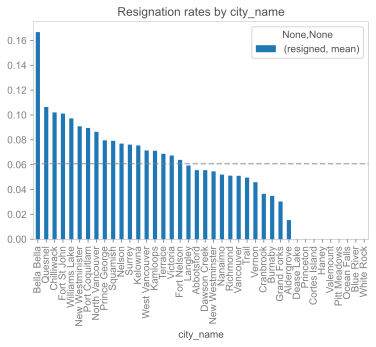

resigned           
                            mean  sum count
department_name                            
Customer Service        0.149580  178  1190
HR Technology           0.111111    1     9
Processed Foods         0.070652   52   736
Dairy                   0.061955   64  1033
Bakery                  0.033408   30   898
Store Management        0.028571    1    35
Produce                 0.025472   27  1060
Meats                   0.023163   29  1252
Investment              0.000000    0     4
Recruitment             0.000000    0     9
Legal                   0.000000    0     3
Labor Relations         0.000000    0     6
Accounting              0.000000    0     6
Information Technology  0.000000    0     5
Accounts Payable        0.000000    0     4
Executive               0.000000    0    10
Employee Records        0.000000    0     6
Compensation            0.000000    0     4
Audit                   0.000000    0     4
Accounts Receiveable    0.000000    0     5

<AxesSubplot:xlabel='department_name'>

Text(0.5, 1.0, 'Resignation rates by department_name')

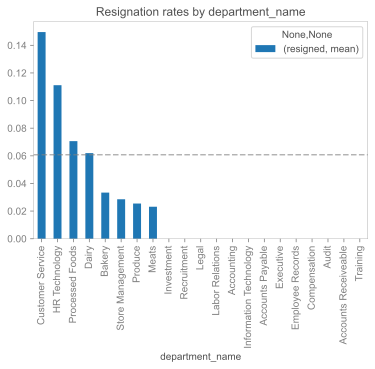

resigned           
                                     mean  sum count
job_title                                           
Cashier                          0.153713  178  1158
HRIS Analyst                     0.125000    1     8
Shelf Stocker                    0.072443   51   704
Dairy Person                     0.062016   64  1032
Baker                            0.034682   30   865
Processed Foods Manager          0.031250    1    32
Store Manager                    0.028571    1    35
Produce Clerk                    0.026290   27  1027
Meat Cutter                      0.023810   29  1218
Exec Assistant, Human Resources  0.000000    0     1
Exec Assistant, Legal Counsel    0.000000    0     1
Exec Assistant, VP Stores        0.000000    0     1
Investment Analyst               0.000000    0     3
Labor Relations Analyst          0.000000    0     5
Legal Counsel                    0.000000    0     1
Accounting Clerk                 0.000000    0     5
Meats Manager                    0.000000    0    34
Director, Training               0.000000    0     1
Produce Manager                  0.000000    0    33
Recruiter                        0.000000    0     8

<AxesSubplot:xlabel='job_title'>

Text(0.5, 1.0, 'Resignation rates by job_title')

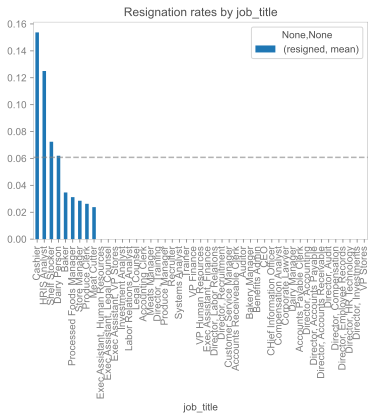

resigned          
                mean sum count
store_name                    
3           0.166667   3    18
28          0.106383  10    94
6           0.102041  15   147
12          0.101124   9    89
44          0.098592  28   284
40          0.097222   7    72
20          0.090909   4    44
25          0.089552   6    67
22          0.086420   7    81
46          0.080460  42   522
26          0.079545  21   264
30          0.079208   8   101
43          0.077170  24   311
19          0.076923   3    39
31          0.076142  15   197
16          0.075410  23   305
38          0.071429   6    84
15          0.071161  19   267
32          0.068750  11   160
11          0.063830   3    47

<AxesSubplot:xlabel='store_name'>

Text(0.5, 1.0, 'Resignation rates by store_name')

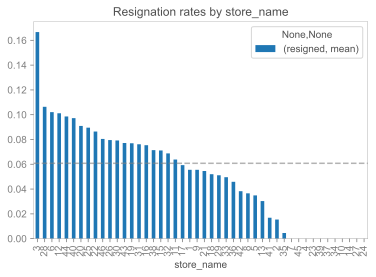

resigned           
                  mean  sum count
gender_short                     
F             0.063453  208  3278
M             0.057884  174  3006

<AxesSubplot:xlabel='gender_short'>

Text(0.5, 1.0, 'Resignation rates by gender_short')

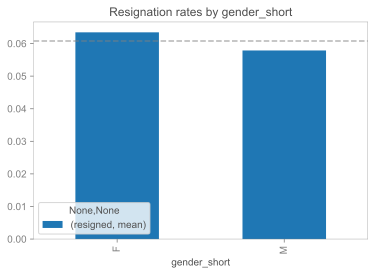

resigned          
                 mean sum count
STATUS_YEAR                    
2011         0.627273  69   110
2012         0.584615  76   130
2013         0.457143  48   105
2010         0.235772  29   123
2014         0.213439  54   253
2008         0.158537  26   164
2007         0.154321  25   162
2009         0.119718  17   142
2006         0.089552  12   134
2015         0.005241  26  4961

<AxesSubplot:xlabel='STATUS_YEAR'>

Text(0.5, 1.0, 'Resignation rates by STATUS_YEAR')

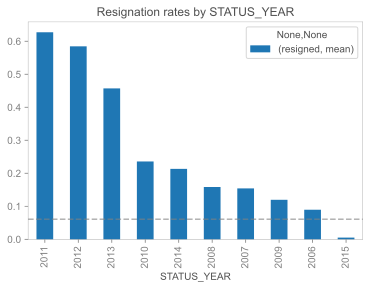

resigned           
                   mean  sum count
BUSINESS_UNIT                     
STORES         0.061412  381  6204
HEADOFFICE     0.012500    1    80

<AxesSubplot:xlabel='BUSINESS_UNIT'>

Text(0.5, 1.0, 'Resignation rates by BUSINESS_UNIT')

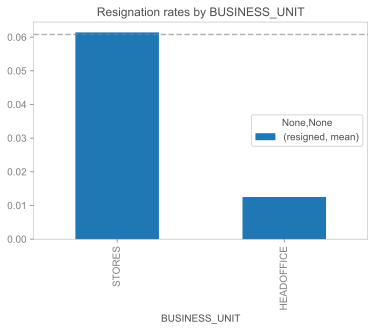

resigned           
                   mean  sum count
job_group                         
Service Staff  0.063125  379  6004
Executive      0.016667    1    60
Manager        0.010000    2   200
C-Suite        0.000000    0     5
Director       0.000000    0    11
Legal          0.000000    0     4

<AxesSubplot:xlabel='job_group'>

Text(0.5, 1.0, 'Resignation rates by job_group')

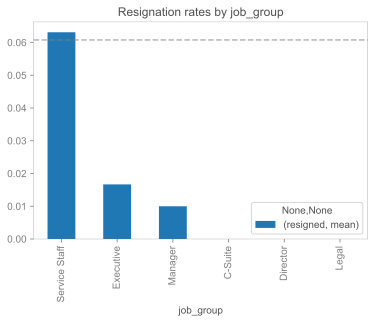

resigned          
                 mean sum count
resig_month                    
10           0.455285  56   123
6            0.403509  46   114
9            0.398230  45   113
2            0.324786  38   117
8            0.280000  21    75
11           0.254717  27   106
3            0.240000  24   100
4            0.215909  19    88
5            0.205357  23   112
7            0.192308  20   104
12           0.095652  33   345
1            0.006139  30  4887

<AxesSubplot:xlabel='resig_month'>

Text(0.5, 1.0, 'Resignation rates by resig_month')

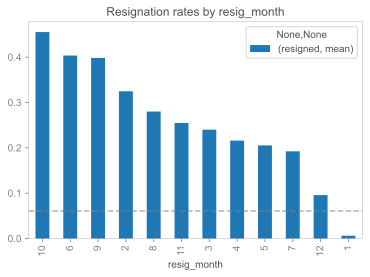

In [47]:
# Baseline
df_max.resigned.sum()
global_resig_rate = df_max.resigned.mean()

for c in categorical:
    df_max.groupby(c).agg({'resigned': ['mean', 'sum', 'count']}).sort_values([('resigned', 'mean')], ascending=False).head(20)
    df_max.groupby(c).agg({'resigned': ['mean']}).sort_values([('resigned', 'mean')], ascending=False).plot.bar()
    plt.title(f"Resignation rates by {c}")
    plt.axhline(y=global_resig_rate, color='gray', alpha=0.6,linestyle='--')
    plt.show()

In [33]:
df_max.dtypes

EmployeeID                      int64
terminationdate_key    datetime64[ns]
city_name                      object
department_name                object
job_title                      object
store_name                      int64
gender_short                   object
termreason_desc                object
termtype_desc                  object
STATUS_YEAR                     int64
STATUS                         object
BUSINESS_UNIT                  object
emp_record_idx                float64
num_records                   float64
num_jobs                        int64
job_group                      object
resigned                        int64
los_days                        int64
age_days                        int64
resig_month                     int64
dtype: object

### Results of Attrition Rate by Category...

<AxesSubplot:xlabel='resig_month'>

<AxesSubplot:xlabel='STATUS_YEAR'>

<AxesSubplot:xlabel='STATUS_YEAR'>

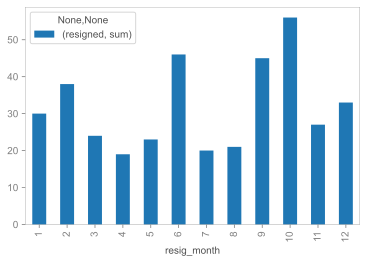

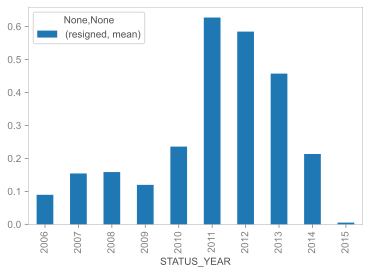

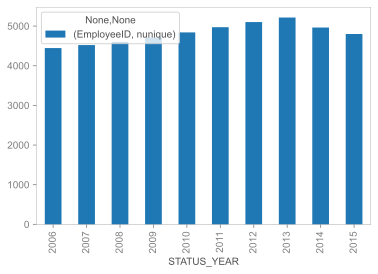

In [53]:
df_max[df_max.resigned==1].groupby('resig_month').agg({'resigned': ['sum']}).plot.bar()
df_max.groupby('STATUS_YEAR').agg({'resigned': ['mean']}).plot.bar()
df[df.STATUS=='ACTIVE'].groupby('STATUS_YEAR').agg({'EmployeeID': ['nunique']}).plot.bar()